<a href="https://colab.research.google.com/github/KevinTheRainmaker/AI_Tutorials/blob/main/TorchAudio/torchaudio_01_Audio_IO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUDIO I/O

이 튜토리얼에서는 `torchaudio`의 기본적인 I/O API를 이용해서 오디오 데이터를 PyTorch Tensor object로 로드하고 
이를 audio file로 저장하는 연습을 진행해보도록 하겠다.

`torchaudio`는 `librosa`를 포함하고 있어 다양한 audio I/O 기능을 제공한다

In [1]:
# download required packages
!pip install -q torchaudio librosa boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 3.7 MB/s eta 0:00:00


In [2]:
# import libraries
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.0.0+cu118
2.0.1+cu118


### Preparation

In [3]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

import warnings
warnings.filterwarnings("ignore")

base_url = 'https://download.pytorch.org/torchaudio/tutorial-assets/'
SAMPLE_MP3_URL = os.path.join(base_url, 'steam-train-whistle-daniel_simon.mp3')
SAMPLE_GSM_URL = os.path.join(base_url, 'steam-train-whistle-daniel_simon.gsm')
SAMPLE_WAV_URL = os.path.join(base_url, 'Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav')
SAMPLE_WAV_8000_URL = os.path.join(base_url, 'Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav')

SAMPLE_MP3 = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.mp3")
SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")

100%|██████████| 39.2k/39.2k [00:00<00:00, 33.1MB/s]
100%|██████████| 7.99k/7.99k [00:00<00:00, 6.71MB/s]
100%|██████████| 106k/106k [00:00<00:00, 24.7MB/s]
100%|██████████| 53.2k/53.2k [00:00<00:00, 48.9MB/s]


### Quering audio metadata

`torchaudio.info` 함수는 audio의 metadata를 불러온다.

path-like object나 file-like object 모두 지원한다.

In [4]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


- `sample_rate`: audio의 sampling rate
- `num_channels`: 채널 수
- `num_frames`: 채널 당 프레임 수
- `bits_per_sample`: bit의 깊이
- `encoding`: sample의 coding format

`encoding`의 가능한 값은 다음과 같다.

- `"PCM_S"`: Signed integer linear PCM
- `"PCM_U"`: Unsigned integer linear PCM
- `"PCM_F"`: Floating point linear PCM
- `"FLAC"`: [Free Lossless Audio Codec](https://xiph.org/flac/)
- `"ULAW"`: [Mu-law](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm)
- `"ALAW"`: [A-law](https://en.wikipedia.org/wiki/A-law_algorithm)
- `"MP3"`: MP3, MPEG-1 Audio Layer III
- `"VORBIS"`: [OGG Vorbis](https://xiph.org/vorbis/)
- `"AMR_NB"`: [Adaptive Multi-Rate](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec)
- `"AMR_WB"`: [Adaptive Multi-Rate Wideband](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband)
- `"OPUS"`: [Opus](https://opus-codec.org/)
- `"GSM"`: [GSM-FR](https://en.wikipedia.org/wiki/Full_Rate)
- `"UNKNOWN"`: None of above

\* Note
- `bits_per_sample`은 압축되었거나 다양한 bit rate를 가지는 포맷에 대해서는 0이 될 수 있다.
- `num_frames`는 `GSM-FR` 포맷에 대해서 0이 될 수 있다.

In [5]:
metadata = torchaudio.info(SAMPLE_MP3)
print(metadata)

metadata = torchaudio.info(SAMPLE_GSM)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=110592, num_channels=2, bits_per_sample=0, encoding=MP3)
AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


### Quering file-like object

`torchaudio.info` 함수는 file-like object에 대해서도 동작한다.

In [6]:
print("Source:", SAMPLE_WAV_URL)
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  metadata = torchaudio.info(response.raw)
print(metadata)

Source: https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav
AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


\*Note
- file-like object를 파라미터로 넘길 때, `info` 함수는 모든 데이터를 읽지 않고 시작 부분만을 읽는다.
- 따라서, 포맷에 따라 올바르지 않은 메타데이터를 얻을 수도 있음에 주의하자.

In [7]:
from io import BytesIO
print("Source:", SAMPLE_MP3_URL)
with requests.get(SAMPLE_MP3_URL, stream=True) as response:
  src = BytesIO(response.content)
  metadata = torchaudio.info(src, format="mp3")

  print(f"Fetched {response.raw.tell()} bytes.")
print(metadata)

Source: https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.mp3
Fetched 40124 bytes.
AudioMetaData(sample_rate=44100, num_frames=110592, num_channels=2, bits_per_sample=0, encoding=MP3)


### Loading audio data into Tensor

audio data를 load 하기 위해서는 `torchaudio.load` 함수를 사용하면 된다.

이 함수는 path-like object와 file-like object를 모두 load 할 수 있다.

return 값은 waveform의 tuple(Tensor)와 sample rate(int)이다.

기본적으로 tensor object의 dtype=torch.float32이고 값 범위는 [-1.0, 1.0] 사이로 normalize 된다.

In [22]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [23]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [24]:
def plot_waveform(waveform, sample_rate, title='Waveform', xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  fig, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for i in range(num_channels):
    axes[i].plot(time_axis, waveform[i], linewidth=1)
    axes[i].grid(True)
    if num_channels > 1:
      axes[i].set_ylabel(f'Channel {i+1}')
    if xlim:
      axes[i].set_xlim(xlim)
    if ylim:
      axes[i].set_ylim(ylim)
  fig.suptitle(title)
  plt.show(block=False)

In [25]:
def plot_specgram(waveform, sample_rate, title='Specgram', xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  fig, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for i in range(num_channels):
    axes[i].specgram(waveform[i], Fs=sample_rate) # different part
    if num_channels > 1:
      axes[i].set_ylabel(f'Channel {i+1}')
    if xlim:
      axes[i].set_xlim(xlim)
    if ylim:
      axes[i].set_ylim(ylim)
  fig.suptitle(title)
  plt.show(block=False)


In [26]:
Audio(waveform.numpy()[0], rate=sample_rate)

In [27]:
print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



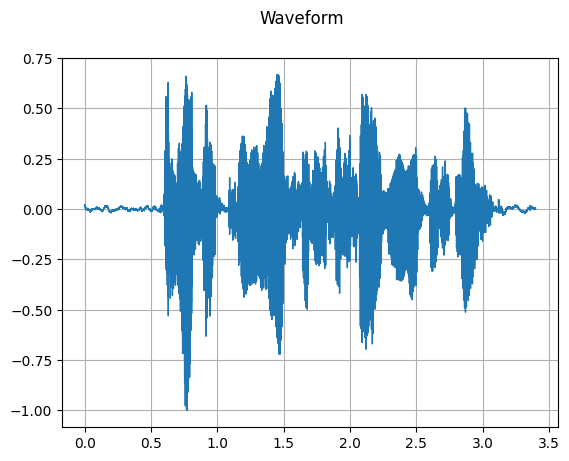

In [28]:
plot_waveform(waveform, sample_rate)

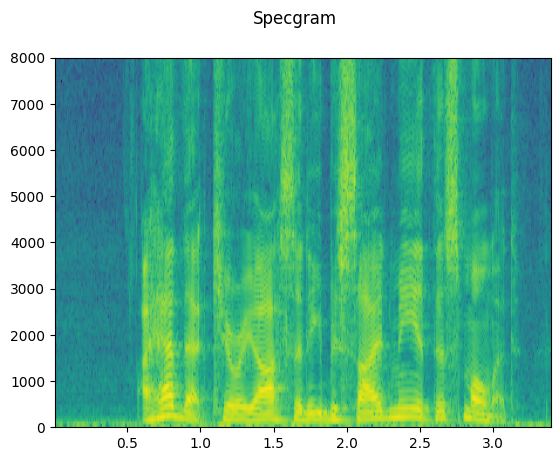

In [29]:
plot_specgram(waveform, sample_rate)

### Loading from file-like object

`torchaudio`의 I/O function은 file-like object의 fetching과 decoding 또한 지원한다.

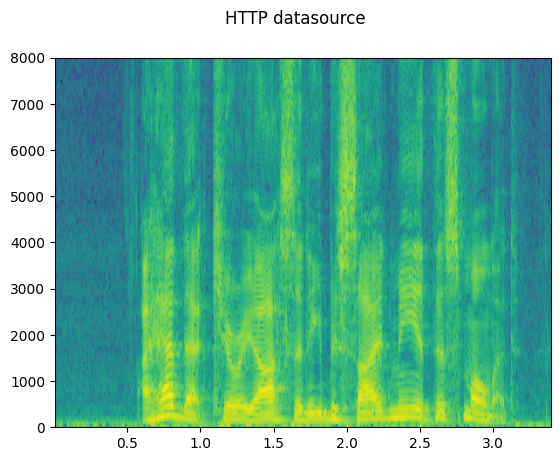

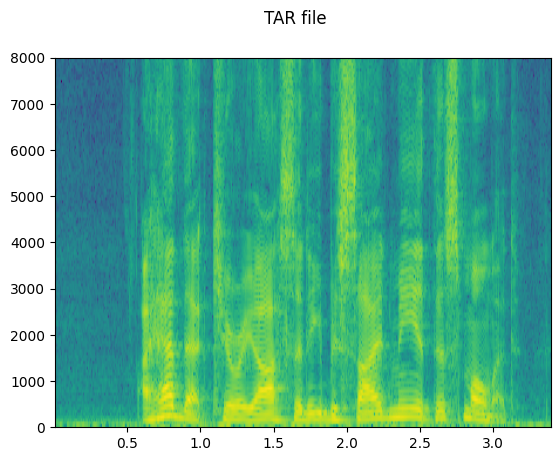

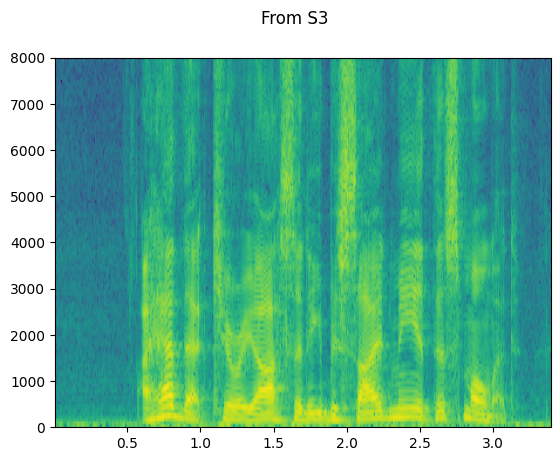

In [30]:
# Load audio data as HTTP request
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

# Load audio from tar file
SAMPLE_TAR_PATH = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with tarfile.open(SAMPLE_TAR_PATH, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(SAMPLE_TAR_ITEM)
  waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

# Load audio from S3
S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
waveform, sample_rate = torchaudio.load(response['Body'])
plot_specgram(waveform, sample_rate, title="From S3")

### Tips on slicing

`num_frames`와 `frame_offset` arguments를 줌으로써 decoding을 제한하여 slicing을 할 수 있다.

일반적인 Tensor slicing을 통해서도 동일한 결과를 얻을 수 있으나, 위 방식을 이용하면 원하는 크기만큼 decoding이 이루어지는 순간 데이터 로드를 중지하기 때문에 더 쉽고 효율적으로 결과를 얻을 수 있다.

In [31]:
frame_offset, num_frames = 16000, 16000

In [32]:
import time

In [33]:
# This will fetch all the data and decode them.
print("Fetching all the data...")
start = time.time()
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  waveform1, sample_rate1 = torchaudio.load(response.raw)
  waveform1 = waveform1[:, frame_offset : frame_offset + num_frames]
  print(f" - Fetched {response.raw.tell()} bytes / time: {time.time() - start}")

Fetching all the data...
 - Fetched 108844 bytes / time: 0.0881493091583252


In [34]:
# This will stop fetching data once it completes decoding.
print("Fetching until the requested frames are available...")
start = time.time()
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  waveform2, sample_rate2 = torchaudio.load(
      response.raw, frame_offset=frame_offset, num_frames=num_frames)
  print(f" - Fetched {response.raw.tell()} bytes / time: {time.time() - start}")

Fetching until the requested frames are available...
 - Fetched 65580 bytes / time: 0.6025049686431885


In [35]:
# The resulting waveforms are identical.
print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

Checking the resulting waveform ... matched!


### Saving audio to file

audio data를 일반적인 어플리케이션에서 해석 가능한 포맷으로 저장하기 위해서는 `torchaudio.save` 함수를 사용하면 된다.

이 함수는 path-like object와 file-like object에 대해 모두 사용 가능하다. 다만 file-like object를 전달할 때는 `format` argument를 함께 전달해야 한다. path-like object를 이용할 때에는 함수가 extension에 따라 포맷을 설정한다. 만약 extension 없이 파일을 저장할 때는 이 경우에도 또한 `format`을 전달해주어야 한다.

WAV 포맷으로 저장할 때, `float32` Tensor의 기본 인코딩은 32-bit floating-point PCM이다. 이를 바꾸기 위해서는 `encoding`과 `bits_per_sample` arguments를 전달할 수 있다.

In [36]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [37]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

In [38]:
print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



In [39]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)
    inspect_file(path)

----------
Source: /tmp/tmpzyiz_k_r/save_example_default.wav
----------
 - File size: 217658 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_F)



In [ ]:
# Save w/o any encoding option
path = 'save_example_default.wav'
torchaudio.save(path, waveform, sample_rate)
inspect_file(path)

----------
Source: save_example_default.wav
----------
 - File size: 437530 bytes
 - AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=1, bits_per_sample=32, encoding=PCM_F)


In [ ]:
# Save as 16-bit signed integer Linear PCM
path = 'save_example_PCM_S16.wav'
torchaudio.save(path, waveform, sample_rate,
                encoding='PCM_S', bits_per_sample=16)
inspect_file(path)

----------
Source: save_example_PCM_S16.wav
----------
 - File size: 218780 bytes
 - AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=1, bits_per_sample=16, encoding=PCM_S)


`torchaudio.save`는 다른 포맷 또한 지원한다.

In [ ]:
waveform, sample_rate = get_sample(resample=8000)

formats = [
    'mp3',
    'flac',
    'vorbis',
    'sph',
    'amb',
    'amr-nb',
    'gsm'
]

for format in formats:
  path = f'save_example.{format}'
  torchaudio.save(path, waveform, sample_rate, format=format)
  inspect_file(path)

----------
Source: save_example.mp3
----------
 - File size: 2664 bytes
 - AudioMetaData(sample_rate=8000, num_frames=21312, num_channels=1, bits_per_sample=0, encoding=MP3)
----------
Source: save_example.flac
----------
 - File size: 47315 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=24, encoding=FLAC)
----------
Source: save_example.vorbis
----------
 - File size: 9967 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=0, encoding=VORBIS)
----------
Source: save_example.sph
----------
 - File size: 80384 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=32, encoding=PCM_S)
----------
Source: save_example.amb
----------
 - File size: 79418 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=32, encoding=PCM_F)
----------
Source: save_example.amr-nb
----------
 - File size: 1618 bytes
 - AudioMetaData(sample_rate=8000, nu

### Save to file-like object

file-like object로 저장할 때는 `format`을 반드시 주어줘야 한다.

In [ ]:
waveform, sample_rate = get_sample()

buffer_ = io.BytesIO()

In [ ]:
torchaudio.save(buffer_, waveform, sample_rate, format='wav')

/usr/local/lib/python3.9/dist-packages/torchaudio/backend/sox_io_backend.py:416: UserWarning: File-like object support in sox_io backend is deprecated, and will be removed in v2.1. See https://github.com/pytorch/audio/issues/2950 for the detail.Please migrate to the new dispatcher, or use soundfile backend.
  warnings.warn(_deprecation_message)


In [ ]:
buffer_.seek(0)

0

In [ ]:
print(buffer_.read(16))

b'RIFF\x12\xad\x06\x00WAVEfmt '
